***

<font color='green'>

# Project Solution: Unsupervised Learning (Support Vector Classifier applied on Principal Components)
### Dataset filename: vehicle-1.csv
### File consists of features extracted from the silhouette of vehicles (bus, van, car) in different angles  
### Purpose: Classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
### Learning outcome: EDA, Dimension reduction using PCA, Train model using Principal Components
***
***
*Prepared by: Sauvik De*

*Date: November 3, 2020*
    
</font>

***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [2]:
# Read in data and store it in variable 
vehicles = pd.read_csv('vehicle-1.csv', sep=',', header=0)

### Exploratory Data Analysis

In [3]:
print(f'The shape of the dataframe is {vehicles.shape}')
print('\nFirst few rows of the dataframe:')
vehicles.head()

The shape of the dataframe is (846, 19)

First few rows of the dataframe:


compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [4]:
# Check columns and their datatypes
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

#### Comments:
1. There seem to be some missing values for couple of features.
2. Datatypes for all the columns are either integer or float type, except for class which is categorical (nominal).

In [5]:
# Missing value analysis
print('\nNo. of features with missing values:', vehicles.columns[vehicles.isnull().sum() != 0].shape[0], 'out of', vehicles.shape[1]-1)
print('No. of records with missing values in any one of the features:', vehicles[vehicles.isnull().any(axis=1)].shape[0], 'out of', vehicles.shape[0])


No. of features with missing values: 14 out of 18
No. of records with missing values in any one of the features: 33 out of 846



Categories of target variable 'class': ['van' 'car' 'bus']

The frequency of each category:
car    429
bus    218
van    199
Name: class, dtype: int64


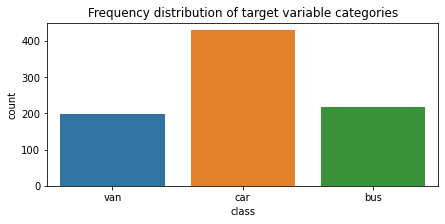

In [6]:
# Target variable analysis
print("\nCategories of target variable 'class':", vehicles['class'].unique())
print("\nThe frequency of each category:")
print(vehicles['class'].value_counts())

plt.figure(figsize=(7,3))
_ = sns.countplot(x=vehicles['class']).set_title('Frequency distribution of target variable categories')

#### Comments:
1. There are no missing values in target variable.
2. There is a presence of class imbalance in data with category 'car' appearing almost twice as the other two categories.

In [7]:
# Rather than casewise deletion of records for missing values, 
# we impute missing values by group median of respective features grouped by vehicle 'class'

for c in vehicles.columns[vehicles.isnull().sum() != 0]:
    vehicles[c].fillna(vehicles.groupby(['class'])[c].transform('median'), inplace=True)

In [8]:
# Look at the descriptive stats to understand the skewness, spread of features

vehicles.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.826241    6.134340   33.0   40.00   
distance_circularity         846.0   82.066194   15.754263   40.0   70.00   
radius_ratio                 846.0  168.916076   33.427561  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.680851    7.882557   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.920804   33.199802  112.0  147.00   
elongatedness                846.0   40.927896    7.813401   26.0   33.00   
pr.axis_rectangularity       846.0   20.579196    2.590879   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.643026   31.378020  130.0  167.00   
scaled_variance.1            846.0  439.665485  176.492876  184.0  318.25   
scaled_radius_of_gyration    846.0  174.712766   32.546284  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.470873   59.0   67.00   
skewness_about               846.0    6.356974    4.904073    0.0    2.00   
skewness_about.1             846.0   12.604019    8.930921    0.0    5.00   
skewness_about.2             846.0  188.919622    6.152167  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                                50%     75%     max  
compactness                   93.00  100.00   119.0  
circularity                   44.00   49.00    59.0  
distance_circularity          80.00   98.00   112.0  
radius_ratio                 167.25  195.00   333.0  
pr.axis_aspect_ratio          61.00   65.00   138.0  
max.length_aspect_ratio        8.00   10.00    55.0  
scatter_ratio                157.00  198.00   265.0  
elongatedness                 43.00   46.00    61.0  
pr.axis_rectangularity        20.00   23.00    29.0  
max.length_rectangularity    146.00  159.00   188.0  
scaled_variance              179.00  217.00   320.0  
scaled_variance.1            364.00  586.75  1018.0  
scaled_radius_of_gyration    174.00  198.00   268.0  
scaled_radius_of_gyration.1   71.00   75.00   135.0  
skewness_about                 6.00    9.00    22.0  
skewness_about.1              11.00   19.00    41.0  
skewness_about.2             188.00  193.00   206.0  
hollows_ratio                197.00  201.00   211.0

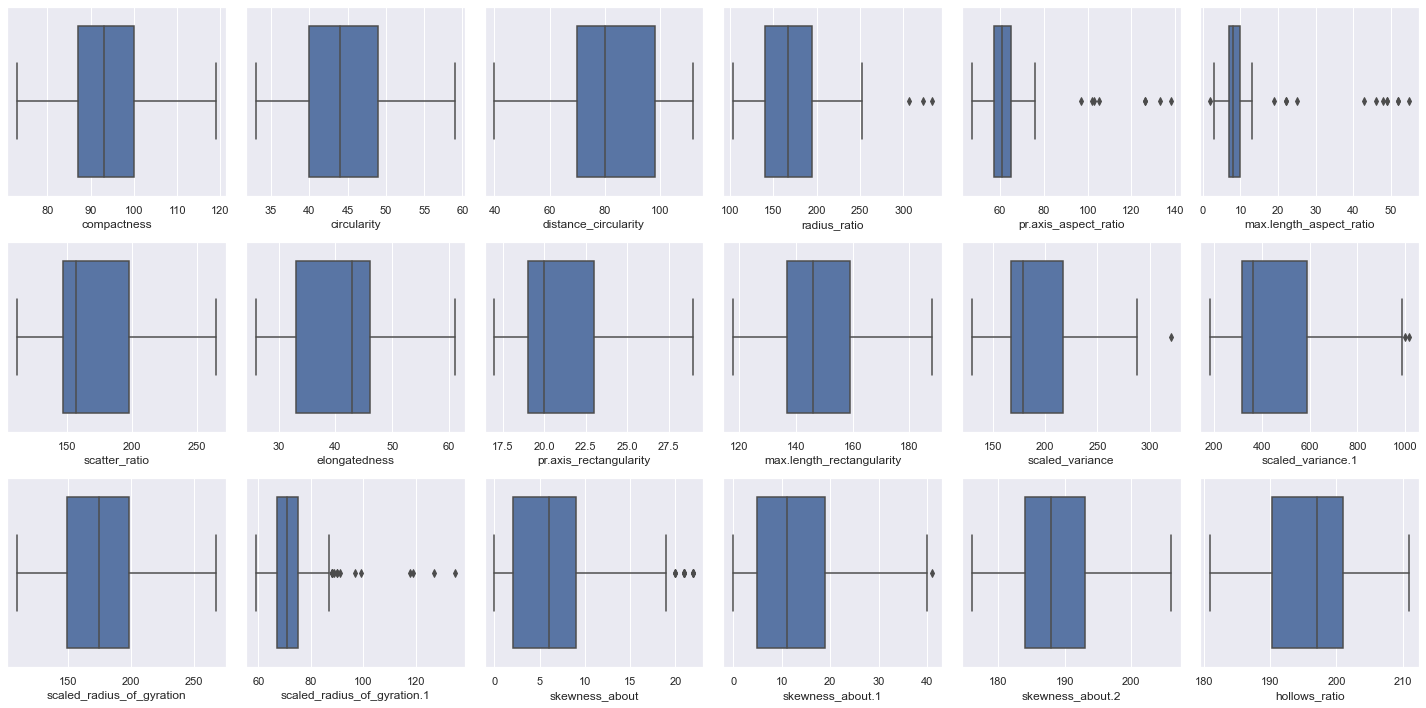

In [9]:
# Outlier analysis
# Let's look at the boxplot for checking outliers

sns.set()
fig, ax = plt.subplots(3, 6, figsize=(30,15))
plt.gcf().set_size_inches(20, 10)

cols = vehicles.columns.drop('class')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        #sns.boxplot(x=vehicles[cols[i*ax.shape[1]+j]], y=vehicles['class'], ax=ax[i,j])
        sns.boxplot(vehicles[cols[i*ax.shape[1]+j]], ax=ax[i,j])
plt.tight_layout()

#### Comments:
1. Looking at the boxplots of features within target categories, there are certainly outliers present in the data.
2. Features compactness, circularity, radius_ratio, scaled_radius_of_gyration, skewness_about_2 seem to be symmetric; while elongatedness, hollows_ratio seem to be negatively skewed; whereas features like pr-axis_rectanguarity, scatter_ratio, sclaed_variance, scaled_variance.1, scaled_radius_of_gyration.1 etc. seem to be positively skewed.
3. Features radius_ratio, pr.axia_aspect_ratio, max.length_aspect_ratio, scaled_radius_of_gyration.1 seem to have outliers.
4. radius_ratio has about 3 outliers on higher side

In [10]:
def outlier_flag(x):
    q3 = np.quantile(x, q=0.75)
    q1 = np.quantile(x, q=0.25)
    return(((x < q1 - 1.5*(q3-q1)) | (x > q3 + 1.5 * (q3 - q1))))

In [11]:
print('No. of outliers in radius_ratio:', outlier_flag(vehicles['radius_ratio']).sum())
print('No. of outliers in pr.axis_aspect_ratio:', outlier_flag(vehicles['pr.axis_aspect_ratio']).sum())
print('No. of outliers in max.length_aspect_ratio:', outlier_flag(vehicles['max.length_aspect_ratio']).sum())
print('No. of outliers in scaled_radius_of_gyration.1:', outlier_flag(vehicles['scaled_radius_of_gyration.1']).sum())

No. of outliers in radius_ratio: 3
No. of outliers in pr.axis_aspect_ratio: 8
No. of outliers in max.length_aspect_ratio: 13
No. of outliers in scaled_radius_of_gyration.1: 15


In [12]:
vehicles2 = vehicles.copy()
vehicles2.drop(vehicles2[outlier_flag(vehicles2['radius_ratio'])].index, axis=0, inplace=True)
vehicles2.drop(vehicles2[outlier_flag(vehicles2['pr.axis_aspect_ratio'])].index, axis=0, inplace=True)
vehicles2.drop(vehicles2[outlier_flag(vehicles2['max.length_aspect_ratio'])].index, axis=0, inplace=True)
vehicles2.drop(vehicles2[outlier_flag(vehicles2['scaled_radius_of_gyration.1'])].index, axis=0, inplace=True)

print('\nAfter removal of outliers, the cleaned dataframe has record count =', vehicles2.shape[0])


After removal of outliers, the cleaned dataframe has record count = 828


In [13]:
vehicles2['class'].value_counts()

car    429
bus    210
van    189
Name: class, dtype: int64

#### Comments
1. There are few number of outliers based on upper and lower whisker points.
2. The outliers don't seem to be errorneous process imputation. On the other hand, we also don't have any way to confirm whether the outliers are potentially wrong.
3. We can remove the outliers as we are planning to use Support Vector Classifier to classify vehicle types, as SVM may be impacted by outliers.
4. We can compare the result with no outliers removed at a later stage to compare the effect of outliers SVM has in classification accuracy
4. We have created deep copy of our dataframe before removing outliers
5. After removal of outliers the reduced record count becomes 828 vs original dataset had 846 records.
6. Notably, no 'car' records removed, 10 'van' records removed, 8 'bus' records removed due to outlier removal process

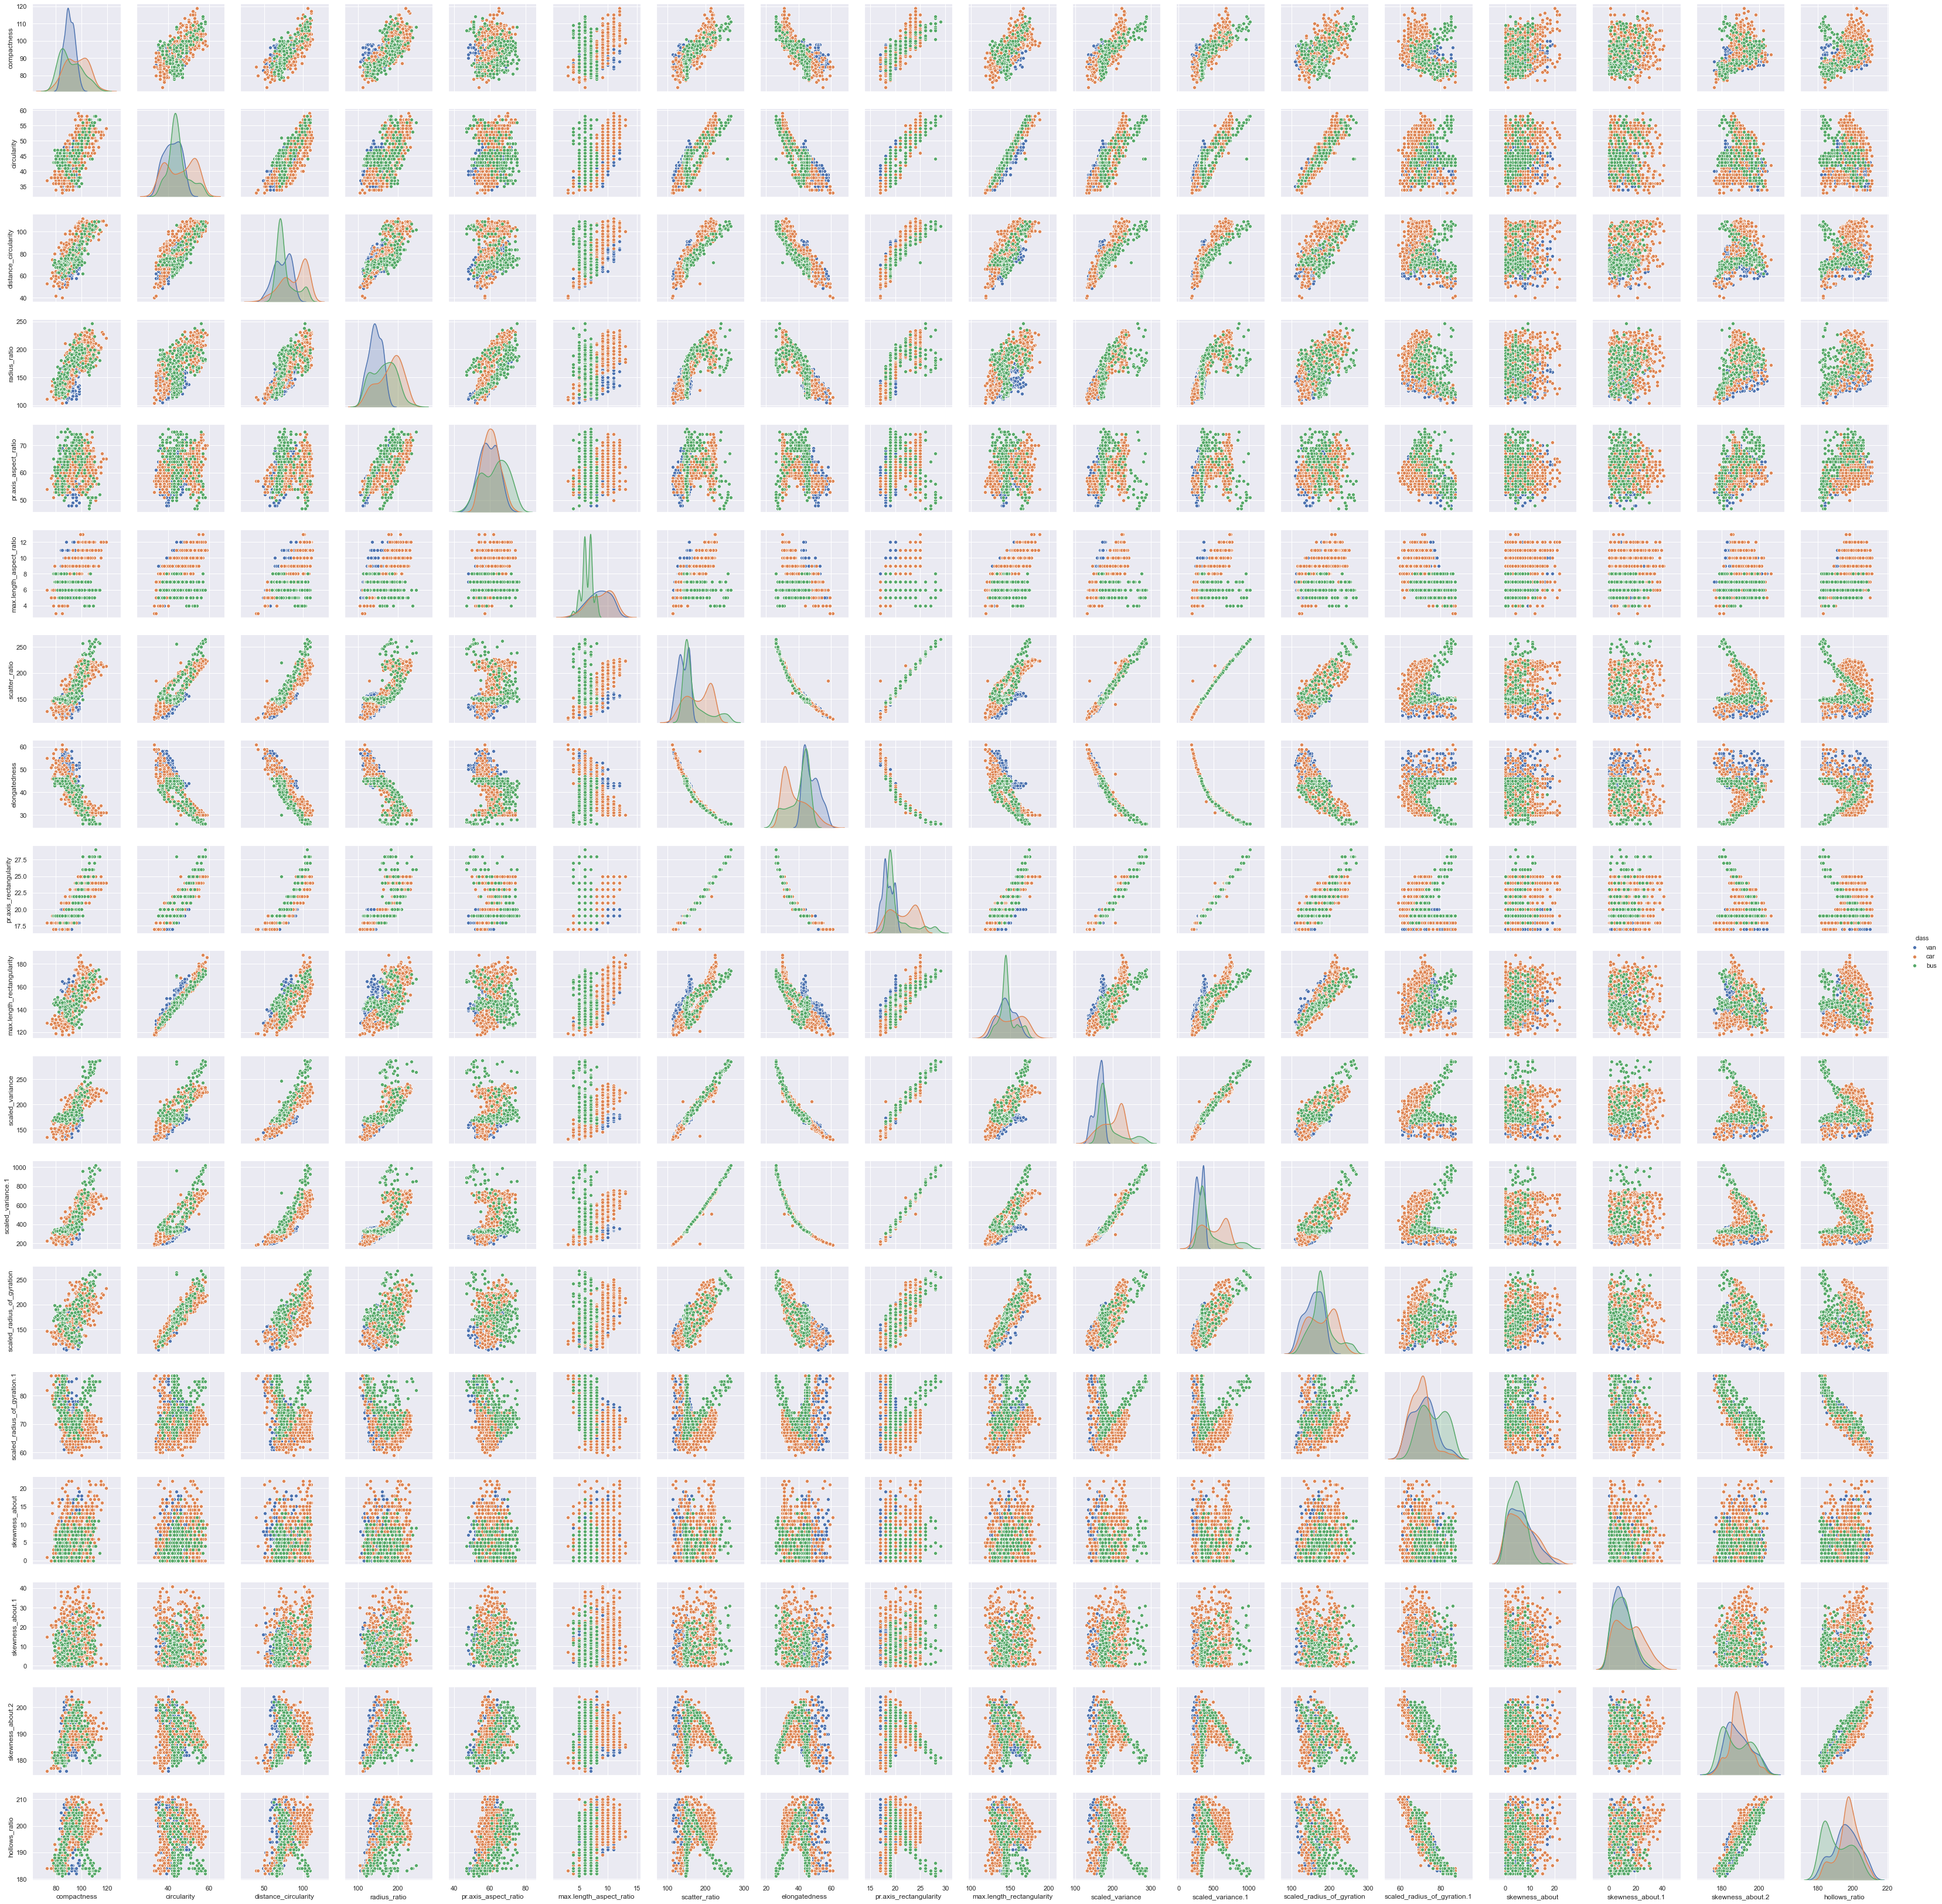

In [14]:
# Let's look at pairplot to understand bivariate relationship among feature variables

_ = sns.pairplot(data=vehicles2, hue='class', diag_kind='kde')

#### Comments:
1. Most of the features have bimodal distribution within each vehicle category
2. Few features like distance_circularity, radius_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness seem to have distinct characteristic across three types of vehicles (e.g.: characteristic on a feature on one class is different from other two classes)
3. There seems to have some strong collinearity among the features. For e.g.: (circularity, max.length_rectangularity), (circularity, scaled_radius_of_gyration), (scatter_ratio, pr.axis_rectangularity), (scatter_ratio, scaled_variance), (scatter_ratio, scaled_variance.1), (skewness_about.2, hollows_ratio) etc.
4. We can certainly look at correlation matrix to look at the highly correlated variables

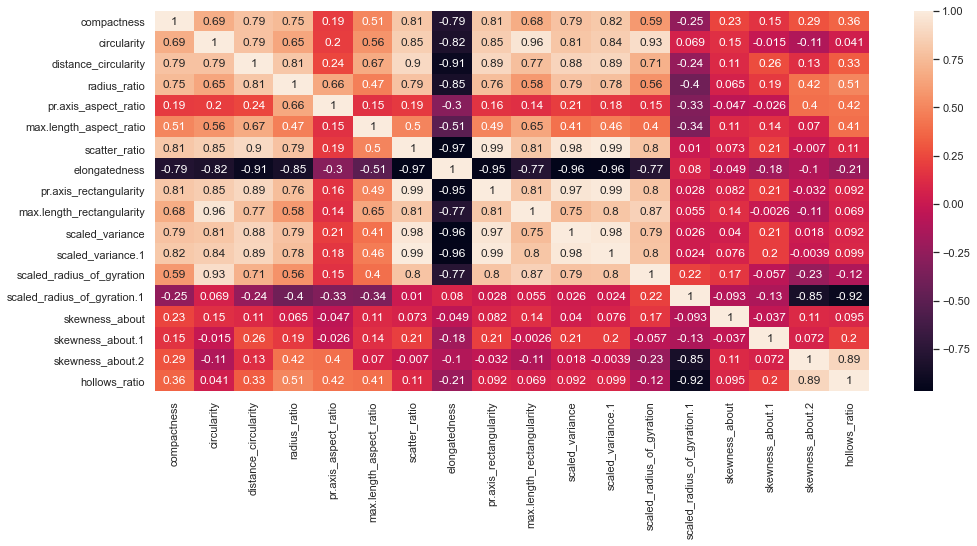

In [15]:
# Correlation matrix
plt.figure(figsize=(16,7))
_ = sns.heatmap(vehicles2.corr(method='pearson'), annot=True)

#### Comments:
1. There are quite a few features that are highly correlated. For example, scaled_variance, scaled_variance.1, scatter_ratio are highly correlated among themselves, and also with several other features.
2. Typically for any supervised Statistical learning models, the information is assumed to contain in axis (dimension) - not in the feature space. That is, there is no correlation between pairs of features; rather the individually 'independent' features are related to the response (target) variable.
2. We may want to remove one of two highly correlated variables in a model to avoid redundancy. For example, we may want remove the following features due to multicollinearity: scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, skewness_about.2

### Fit SVC on manually selected set of columns excluding highly correlated features

In [16]:
# Removing highly correlated variables manually

vehicles2_f = vehicles2.drop(columns = ['scatter_ratio', 'elongatedness', 'pr.axis_rectangularity', 
                                        'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1', 
                                        'scaled_radius_of_gyration', 'skewness_about.2'], axis=1, inplace=False)

vehicles2_f['class'].replace({"bus": 0, "car": 1, "van": 2}, inplace = True)

In [17]:
# Split data into training and test set before building model

X = vehicles2_f.drop(columns='class', axis=1, inplace=False)
y = vehicles2_f['class']

# using stratified split since there is some amount of class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Standardize feature space to make SVC more efficient
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)

In [18]:
# Build SV Classifier model on training dataset

clf = SVC(kernel='rbf')
clf.fit(X_train_sc, y_train)

SVC()


Training set accuracy score (SVC): 0.9602763385146805
Test set accuracy score (SVC): 0.9598393574297188

Classification report for SVC using Test dataset:
[0=Bus, 1=Car, 2=Van]

              precision    recall  f1-score   support

           0     0.9531    0.9683    0.9606        63
           1     0.9769    0.9845    0.9807       129
           2     0.9273    0.8947    0.9107        57

    accuracy                         0.9598       249
   macro avg     0.9524    0.9492    0.9507       249
weighted avg     0.9595    0.9598    0.9596       249



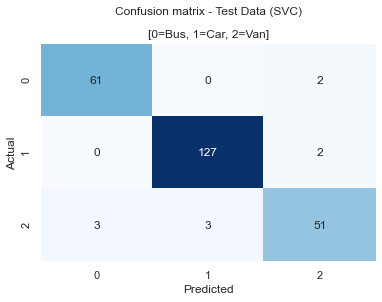

In [19]:
# Evaluate the accuracy, recall, and precision of SVC on test dataset
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

print("\nTraining set accuracy score (SVC):", accuracy_score(y_train, clf.predict(X_train_sc)))
print("Test set accuracy score (SVC):", accuracy_score(y_test, clf.predict(X_test_sc)))

print('\nClassification report for SVC using Test dataset:\n[0=Bus, 1=Car, 2=Van]\n')
print(classification_report(y_test, clf.predict(X_test_sc), digits=4))

cm_svc = confusion_matrix(y_test, clf.predict(X_test_sc))
sns.heatmap(cm_svc, annot = True, cmap = "Blues", fmt = 'd', cbar = False).\
 set_title('Confusion matrix - Test Data (SVC)\n\n[0=Bus, 1=Car, 2=Van]')

_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### Comments:
1. Support Vector Classifier (SVC) performed well with an overall accuracy of ~96% on test dataset.
2. Precision and Recall for vehicle class 'Van' is on a lower side primarily due to smaller sample size.

#### Strategy:
- Till now, we have manually dropped redundant features and built SVC model on the reduced dataset.
- Rather than dropping features, we can utilize the information contained in correlation between variables using Principal Component Analysis (PCA). This will help in both improving signal-to-noise ratio and reducing the dimension of feature space. 
- As our goal is to classify the vehicle types based on input features, predictive accuracy is more important over model explainability.
- As PCA works using linear combination of original variables, the interpretability of new principal components gets lost. However, it will help us explain the high dimensional feature space using low number of components without much loss of information.
- Since, we have multiple features having high collinearity among them, and keeping in mind the main goal of the exercise is to predict class accuracy, PCA would be a very suitable technique that can be applied in this situation.

In [20]:
# Preparing data for applying PCA

# We go back to the original dataset

vehicles2['class'].replace({"bus": 0, "car": 1, "van": 2}, inplace=True)
y = vehicles2['class']
X = vehicles2.drop(columns='class', axis=1, inplace=False)

# using stratified split since there is some amount of class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Standardize feature space
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)

### Principal Component Analysis

In [21]:
# Apply PCA

# Calculate covariance matrix of features
cov_matrix = np.cov(X_train_sc.T)

#print('Covariance matrix:')
#pd.DataFrame(cov_matrix, index=X_train.columns, columns=X_train.columns)

# Compute Eigen values and Eigen vectors of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

print('\nEigen values: \n', eig_vals)
print('\nEigen vectors (columns representing eigen vectors):')
pd.DataFrame(eig_vecs)


Eigen values: 
 [9.87835873e+00 3.37276246e+00 1.19814408e+00 1.12684535e+00
 8.52660023e-01 6.79739174e-01 3.13290995e-01 2.27073538e-01
 1.07866622e-01 7.50543927e-02 5.91863020e-02 4.24353457e-02
 2.98587818e-02 2.74323381e-02 8.43468728e-04 6.83594078e-03
 1.91392571e-02 1.36150712e-02]

Eigen vectors (columns representing eigen vectors):


0         1         2         3         4         5         6  \
0  -0.272400 -0.067857  0.052566  0.114488 -0.134587  0.267559 -0.282179   
1  -0.285800  0.119728  0.210546 -0.055152  0.143771 -0.096789  0.372929   
2  -0.301507 -0.037883 -0.060740  0.118185  0.082139 -0.004847 -0.128105   
3  -0.273141 -0.200111 -0.081064 -0.228937 -0.136874 -0.137002 -0.164954   
4  -0.093474 -0.275164  0.026892 -0.578893 -0.147695 -0.604762 -0.131411   
5  -0.195082 -0.124459  0.179803  0.313216  0.597969 -0.283998 -0.406019   
6  -0.308759  0.084785 -0.109910 -0.004457 -0.074610  0.094507 -0.080572   
7   0.307068 -0.017620  0.104687  0.077509  0.063599 -0.068401  0.090868   
8  -0.305442  0.098778 -0.108464  0.019407 -0.072182  0.101273 -0.080694   
9  -0.277239  0.114250  0.229165  0.026557  0.253468 -0.094934  0.322490   
10 -0.301173  0.087532 -0.146596 -0.056323 -0.136059  0.145041 -0.064778   
11 -0.305012  0.094198 -0.113132 -0.009430 -0.108614  0.135789 -0.059657   
12 -0.262080  0.203374  0.207803 -0.103762 -0.002018 -0.081023  0.465566   
13  0.054052  0.503944 -0.053262 -0.113766 -0.145825 -0.144996 -0.111740   
14 -0.042528 -0.031278  0.565268  0.456583 -0.604505 -0.250547 -0.096537   
15 -0.064787 -0.056978 -0.648893  0.480351 -0.141237 -0.446448  0.285955   
16 -0.044865 -0.498776  0.030105 -0.045747 -0.175111  0.297588  0.263212   
17 -0.093091 -0.503198  0.021661  0.094185  0.098335  0.057172  0.181479   

           7         8         9        10        11        12        13  \
0  -0.767178 -0.306999 -0.117359  0.062989 -0.024525 -0.090727 -0.160467   
1  -0.108490 -0.055906  0.294493  0.050840  0.108432 -0.414672  0.076452   
2   0.308724 -0.262637  0.005054  0.754253 -0.327401  0.065362  0.057992   
3   0.060464 -0.190411  0.098886 -0.103526  0.274843 -0.279091  0.659349   
4  -0.138454  0.022920  0.008014  0.034805 -0.150020  0.202674 -0.266827   
5   0.001900  0.174932 -0.275308 -0.130875  0.205976  0.119958  0.085750   
6   0.101856  0.135996  0.076660 -0.173160 -0.058890 -0.001168 -0.066693   
7  -0.249291 -0.202950  0.064364 -0.059824 -0.382844  0.386150  0.580419   
8   0.040969  0.122981  0.130722 -0.312844 -0.303332  0.202779  0.044224   
9  -0.242479  0.243568  0.405966  0.146044  0.037425  0.271998 -0.033614   
10  0.148436  0.067659 -0.123278  0.050923  0.177602  0.204613  0.025343   
11  0.058963  0.120868  0.099520 -0.246329 -0.218793  0.200792  0.096035   
12  0.080998 -0.322068 -0.656851 -0.162487 -0.029450  0.113175 -0.000882   
13 -0.243493  0.547614 -0.315601  0.285384 -0.118286 -0.210522  0.265560   
14  0.145838  0.062514  0.065742 -0.023121  0.009302 -0.002163 -0.014840   
15 -0.163749 -0.039732 -0.014444 -0.003907  0.095666  0.023364 -0.027624   
16 -0.094416  0.356145 -0.174652  0.242842  0.318768  0.305266  0.161122   
17  0.013277  0.277508 -0.175293 -0.109955 -0.539822 -0.430023 -0.000230   

          14        15        16        17  
0  -0.003002  0.007890  0.028084  0.001541  
1  -0.002596 -0.107102 -0.546216  0.289666  
2  -0.000520  0.010226 -0.079744 -0.110989  
3  -0.034097  0.010577  0.269747 -0.197571  
4   0.020006  0.001743 -0.108462  0.083489  
5  -0.011148  0.001332 -0.153641  0.038954  
6   0.815787  0.333092 -0.094012 -0.080281  
7   0.226654  0.022481 -0.098611  0.257343  
8  -0.054023 -0.692437 -0.162291 -0.295391  
9  -0.017030  0.065116  0.523752 -0.141371  
10  0.026453 -0.224364  0.259036  0.772421  
11 -0.525562  0.583787 -0.211119  0.061150  
12  0.008741  0.036350  0.069232 -0.157072  
13 -0.008745 -0.009793 -0.020342 -0.054099  
14 -0.003157 -0.004167  0.022074  0.028937  
15 -0.010047  0.006637 -0.020386 -0.009266  
16  0.031018 -0.021154 -0.297851 -0.146946  
17 -0.008170 -0.002997  0.246280  0.160782

In [22]:
# Sort Eigen values in descending order and calculate cumulative proportion of variances of eigen vectors
# The higher the eigen value, the more information content is in the corresponding eigen vector

tot_var = sum(eig_vals)
var_exp = [ (i/tot_var) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print('\nVariance explained by individual principal components:\n', var_exp)
print('\nCumulative variance explained by principal components:\n', cum_var_exp)


Variance explained by individual principal components:
 [54.78498698812224, 18.705207276456605, 6.644859729687933, 6.249439743675104, 4.728818779381058, 3.7698065882241734, 1.7374994741833165, 1.2593408647650672, 0.5982240215817145, 0.4162486948984575, 0.32824489125574763, 0.2353447498874013, 0.16559562362835595, 0.15213866259840444, 0.10614556316704542, 0.07550864692064692, 0.03791185734435937, 0.004677844222348836]

Cumulative variance explained by principal components:
 [ 54.78498699  73.49019426  80.13505399  86.38449374  91.11331252
  94.88311911  96.62061858  97.87995944  98.47818347  98.89443216
  99.22267705  99.4580218   99.62361743  99.77575609  99.88190165
  99.9574103   99.99532216 100.        ]


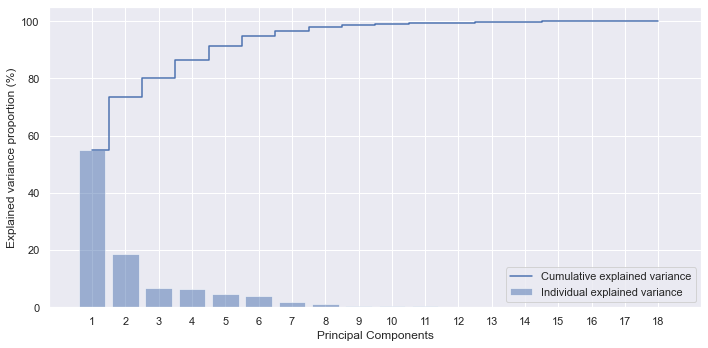

In [23]:
# Visual representation of contribution to explaining variability by principal components

plt.figure(figsize=(10,5))
plt.bar(range(1, eig_vals.size+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, eig_vals.size+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance proportion (%)')
plt.xlabel('Principal Components')
plt.xticks(ticks=range(1,eig_vals.size+1), labels=range(1,eig_vals.size+1))
plt.legend(loc='best')
plt.tight_layout()

#### Comments:
- From the above plot, it is clearly evident that we can explain almost 98% of variability in data using first 8 Principal components.

In [24]:
# Compute projected feature space on a reduced dimension

# Using first 8 PCs as they cover almost 98% of variability in feature space
pca = PCA(n_components=8)
X_train_proj = pca.fit_transform(X_train_sc)
X_test_proj  = pca.transform(X_test_sc)

In [25]:
# Alternative way to deduce the projected training and test set using PC approach

# Make a set of (eigen value, eigen vector) pairs
#eig_pairs = [(eig_vals[index], eig_vecs[:,index]) for index in range(len(eig_vals))]

# Sort the (eigen value, eigen vector) pairs from highest to lowest w.r.t. Eigen value
#eig_pairs.sort(reverse=True)

# Extract the descending ordered eigen values and eigen vectors
#eigvalues_sorted  = [eig_pairs[index][0] for index in range(len(eig_vals))]
#eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eig_vals))]

# Dimesionality reduction
# =======================
# Selecting first 8 eigen vectors out of 18
#feature_reduced = np.array(eigvectors_sorted[0:8]).T

# projecting training data onto the eight eigen vectors
#X_train_proj = np.dot(X_train_sc, feature_reduced)

# projecting test data onto the eight eigen vectors
#X_test_proj = np.dot(X_test_sc, feature_reduced)

In [26]:
print('Shape of projected training feature space:', X_train_proj.shape)
print('Shape of projected test feature space:', X_test_proj.shape)
print('The dimension of feature space reduced to', X_train_proj.shape[1], 'using PCA technique')

Shape of projected training feature space: (579, 8)
Shape of projected test feature space: (249, 8)
The dimension of feature space reduced to 8 using PCA technique


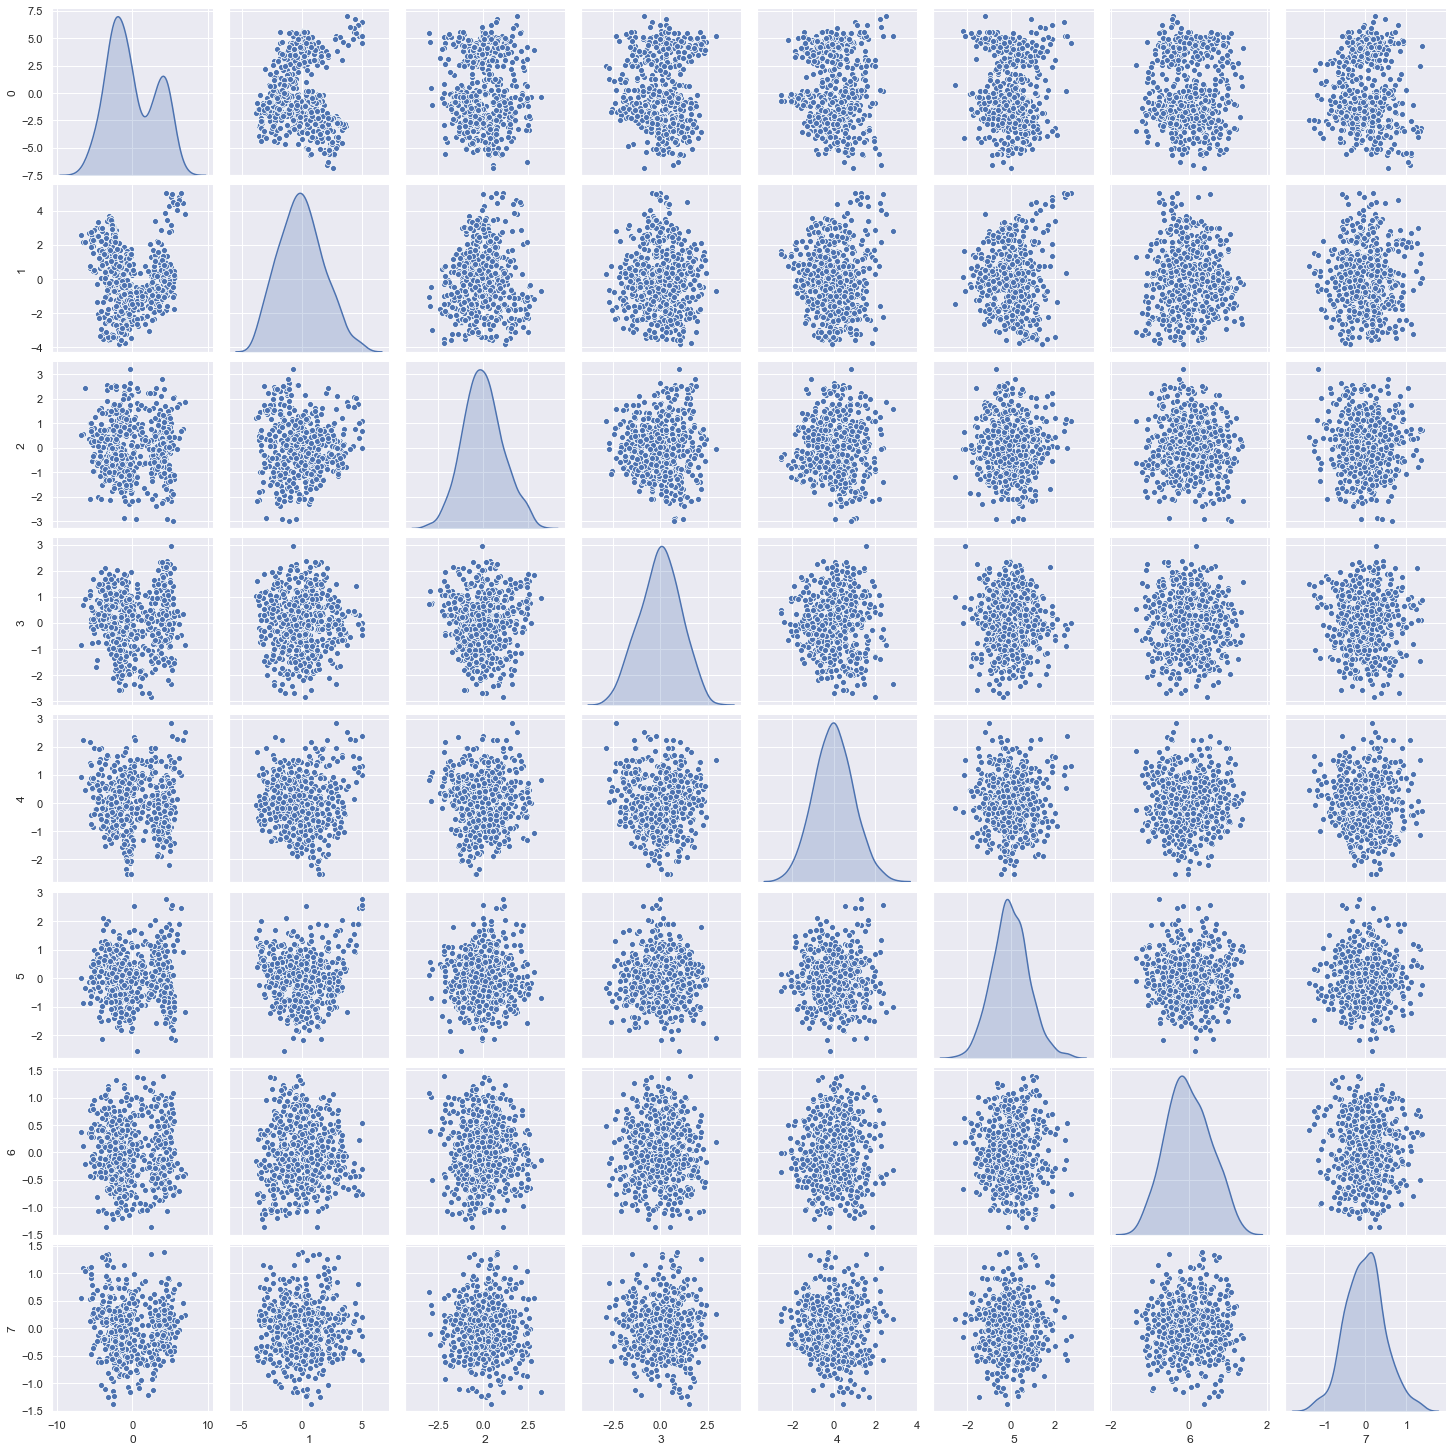

In [27]:
# Let's quickly look at the effect of PCA on features in reduced dimension

_ = sns.pairplot(pd.DataFrame(X_train_proj), diag_kind='kde')

#### Comments:
- As we can see, there is hardly any correlation among the first 8 principal components which is one goal for applying PCA on highly correlated set of features.

### Fit SVC on first 8 Principal Components in reduced dimension

In [28]:
# Next we will fit SVC based on the reduced dimensioned dataframe

# Build SV Classifier model
clf = SVC(kernel='rbf')
clf.fit(X_train_proj, y_train)

SVC()


Training set accuracy score (SVC on PC): 0.9620034542314335
Test set accuracy score (SVC on PC): 0.963855421686747

Classification report for SVC (applied on PC) using Test dataset:
[0=Bus, 1=Car, 2=Van]

              precision    recall  f1-score   support

           0     0.9836    0.9524    0.9677        63
           1     0.9843    0.9690    0.9766       129
           2     0.9016    0.9649    0.9322        57

    accuracy                         0.9639       249
   macro avg     0.9565    0.9621    0.9588       249
weighted avg     0.9652    0.9639    0.9642       249



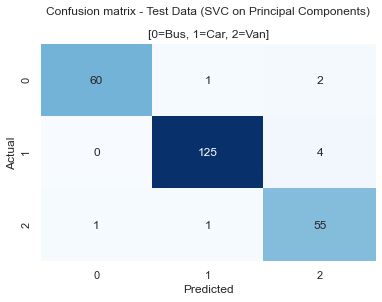

In [29]:
# Evaluate the accuracy, recall, and precision of SVC on test data based on PCs
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

print("\nTraining set accuracy score (SVC on PC):", accuracy_score(y_train, clf.predict(X_train_proj)))
print("Test set accuracy score (SVC on PC):", accuracy_score(y_test, clf.predict(X_test_proj)))

print('\nClassification report for SVC (applied on PC) using Test dataset:\n[0=Bus, 1=Car, 2=Van]\n')
print(classification_report(y_test, clf.predict(X_test_proj), digits=4))

cm_svc = confusion_matrix(y_test, clf.predict(X_test_proj))
sns.heatmap(cm_svc, annot = True, cmap = "Blues", fmt = 'd', cbar = False).\
 set_title('Confusion matrix - Test Data (SVC on Principal Components)\n\n[0=Bus, 1=Car, 2=Van]')

_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### Comments:
1. Applying SVC on reduced dimension using 8 PCs improves overall test accuracy marginally at 96.39% (vs. 95.98% earlier with manually selected features).
2. This is mainly attributed due to improvement in recall score for vehicle class 'van'.
3. The number of features selected using raw data is 10 and obtained overall test accuracy of 95.98%, while using 8 PCs (i.e., 8 newly contructed features) the overall test accuracy is higher at 96.39%. So PCA definitely helps albeit marginally.
4. Using Principal components on highly correlated features helps reduce noise, extract useful information from the correlation, helps in reducing dimension and hence helps in avoiding overfit.
5. On SVC, we have applied Support Vector Machine using the default parameters (C=1, kernel='rbf' and gamma='scale'). We could also do hyperparameter tuning to improve the model accuracy. 
6. **Final conclusion**: If interpretability of the model is required we may want to use raw data for this exercise as model improvement using PCA is not huge. However, in terms of having better accuracy and objectively selecting features in reduced dimension in the presence of highly correlated features, PCA must be used before fitting SVC.

### Optional: Clustering
#### Use cluster ID as an additional feature along with the other 8 Principal Components, and apply SVC

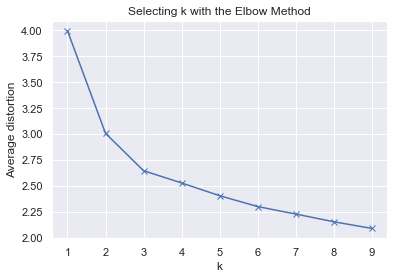

In [30]:
# Apply K-Means Clustering on Principal Components Train Data

# Finding optimal no. of clusters
clusters = range(1,10)
meanDistortions=[]

# compute average within cluster variance for each no. of clusters (K)
for k in clusters:
    mdl = KMeans(n_clusters=k, random_state=1)
    mdl.fit(X_train_proj)
    prediction = mdl.predict(X_train_proj)
    meanDistortions.append(sum(np.min(cdist(X_train_proj, mdl.cluster_centers_, 'euclidean'), axis=1)) / X_train_proj.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
_ = plt.title('Selecting k with the Elbow Method')

#### Comments:
- Elbow plot provides the number of clusters (K) = 3

In [31]:
# Apply K-Means Clustering to projected training dataset, and apply the same transformation to projected test dataset

mdl = KMeans(n_clusters=3, random_state=1)
mdl.fit(X_train_proj)
train_cluster_pred = mdl.labels_
test_cluster_pred  = mdl.predict(X_test_proj)

In [32]:
# Add cluster IDs as new column to both projected training and test datasets

X_train_proj_new = pd.DataFrame(X_train_proj)
X_train_proj_new['CLUSTER'] = train_cluster_pred

X_test_proj_new = pd.DataFrame(X_test_proj)
X_test_proj_new['CLUSTER'] = test_cluster_pred

In [33]:
# Create one-hot-encoding of CLUSTER ID column

tmp = pd.get_dummies(X_train_proj_new['CLUSTER'], prefix='Cluster', drop_first=True)
X_train_proj_new = X_train_proj_new.join(tmp)
X_train_proj_new.drop(columns='CLUSTER', axis=1, inplace=True)

tmp = pd.get_dummies(X_test_proj_new['CLUSTER'], prefix='Cluster', drop_first=True)
X_test_proj_new = X_test_proj_new.join(tmp)
X_test_proj_new.drop(columns='CLUSTER', axis=1, inplace=True)

In [34]:
# Next we will fit SVC

clf = SVC(kernel='rbf')
clf.fit(X_train_proj_new, y_train)

SVC()


Training set accuracy score (SVC on PC with cluster ID): 0.9671848013816926
Test set accuracy score (SVC on PC): 0.9598393574297188

Classification report for SVC (applied on PC with cluster ID) using Test dataset:
[0=Bus, 1=Car, 2=Van]

              precision    recall  f1-score   support

           0     0.9833    0.9365    0.9593        63
           1     0.9766    0.9690    0.9728       129
           2     0.9016    0.9649    0.9322        57

    accuracy                         0.9598       249
   macro avg     0.9538    0.9568    0.9548       249
weighted avg     0.9611    0.9598    0.9601       249



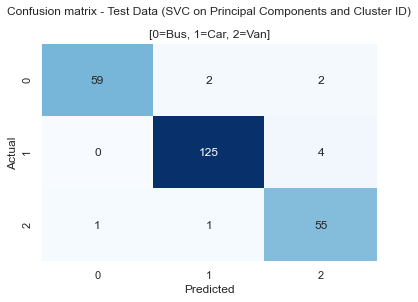

In [35]:
# Evaluate the accuracy, recall, and precision of SVC on test data based on PCs and cluser ID feature
# Also, capture the predicted values and cross-tab of actual vs predicted using confusion matrix

print("\nTraining set accuracy score (SVC on PC with cluster ID):", accuracy_score(y_train, clf.predict(X_train_proj_new)))
print("Test set accuracy score (SVC on PC):", accuracy_score(y_test, clf.predict(X_test_proj_new)))

print('\nClassification report for SVC (applied on PC with cluster ID) using Test dataset:\n[0=Bus, 1=Car, 2=Van]\n')
print(classification_report(y_test, clf.predict(X_test_proj_new), digits=4))

cm_svc = confusion_matrix(y_test, clf.predict(X_test_proj_new))
sns.heatmap(cm_svc, annot = True, cmap = "Blues", fmt = 'd', cbar = False).\
 set_title('Confusion matrix - Test Data (SVC on Principal Components and Cluster ID)\n\n[0=Bus, 1=Car, 2=Van]')

_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### Comments:
1. Inclusion of clustering ID into SVM model to classify vehicle types doesn't increase accuracy with same default SVC hyperparameter settings as before (C=1, kernel='rbf', gamma='scale').
2. Overall test accuracy remains at 95.98%. So there is no improvement in accuracy due to inclusion of cluster ID compared to the other two approaches we performed earlier.

## <center><font color='green'>*******End of Project Solution*******</font></center>